In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_excel('premiums.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


### Data cleaning and EDA:

In [3]:
df.shape

(50000, 13)

In [4]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

##### Correcting the Header Structure

In [5]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053


##### Handing NA values

In [6]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [7]:
df.dropna(inplace = True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

##### Checking for duplicate

In [8]:
df.duplicated().sum()
df.drop_duplicates(inplace= True)
df.duplicated().sum()

np.int64(0)

In [9]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


##### Handing the outlier for number_of_dependants column

In [10]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-3, -1])

##### Let's convert the negative numbers to positive.

In [11]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

##### Checking outliers in the numeric columns

In [12]:
numeric_columns = df.select_dtypes(['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

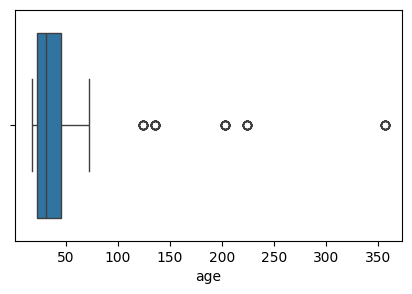

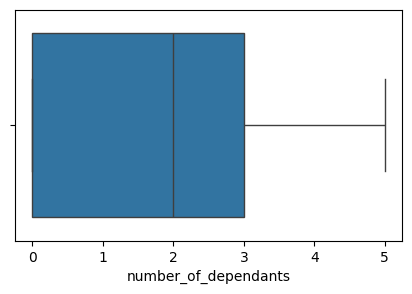

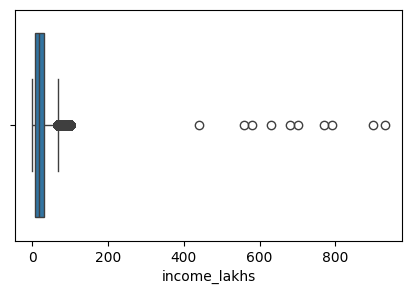

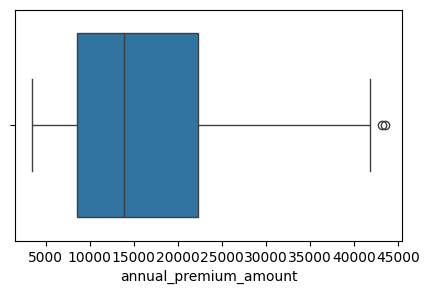

In [13]:
for col in numeric_columns:
    plt.figure(figsize=(5,3))
    sns.boxplot(x = df[col])
    plt.show()

In [14]:
df[df.age>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [15]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

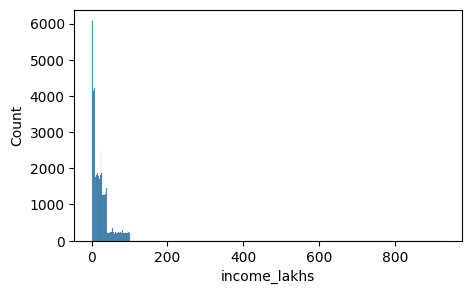

In [16]:
plt.figure(figsize=(5,3))
sns.histplot(df1.income_lakhs)

##### Lets use IQR(InterQuertile Range) method to treat outlier in the income_lakhs column

In [17]:
df1.income_lakhs.quantile([0.25,0.75])

0.25     7.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [18]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [19]:
df1[df1.income_lakhs > quantile_threshold].shape ### As there as no many records we can drop them.

(10, 13)

In [20]:
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


##### Lets analyse the disribution of the numeric data columns in our datset:

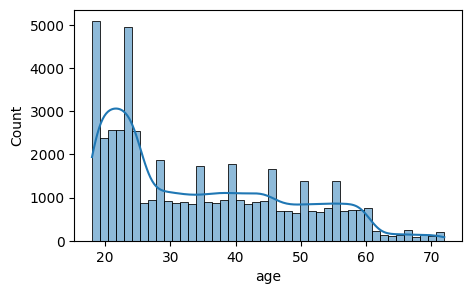

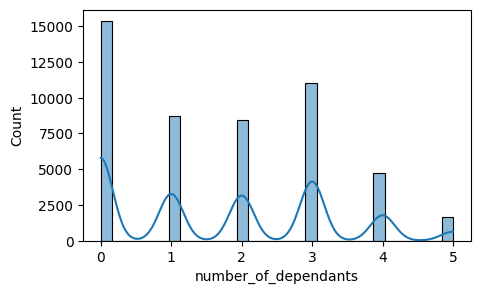

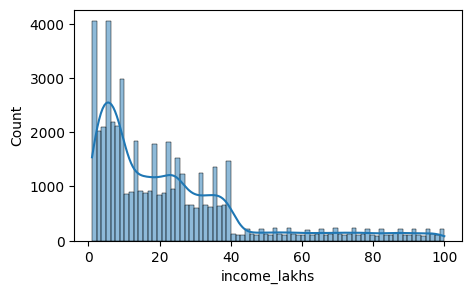

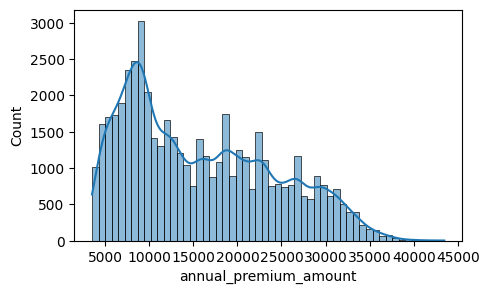

In [21]:
for col in numeric_columns:
    plt.figure(figsize=(5,3))
    sns.histplot(df2[col],kde = True)
    plt.show()

##### We can make the visuals like this also.

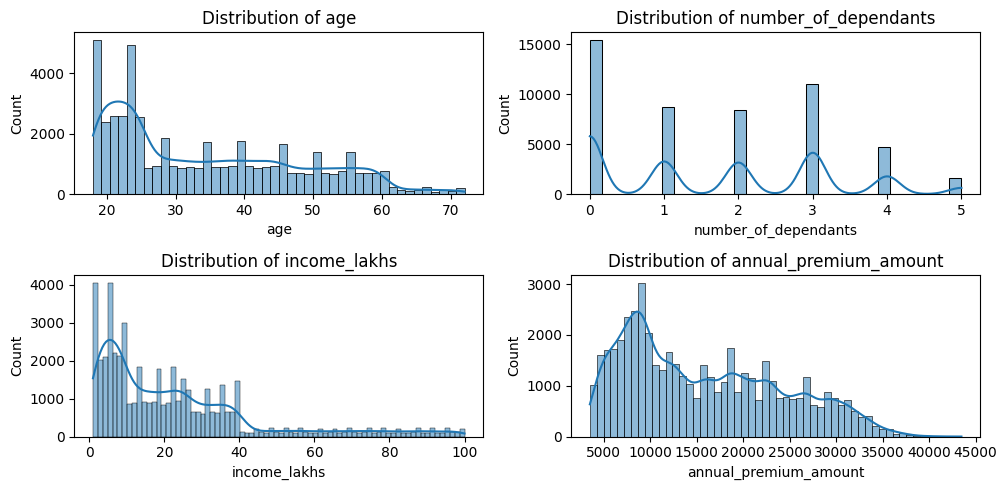

In [22]:
cols_to_plot = numeric_columns[:4]
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

# Flatten axes array for easy indexing
axs = axs.flatten()

# Plot each histogram
for i, col in enumerate(cols_to_plot):
    sns.histplot(df2[col], kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

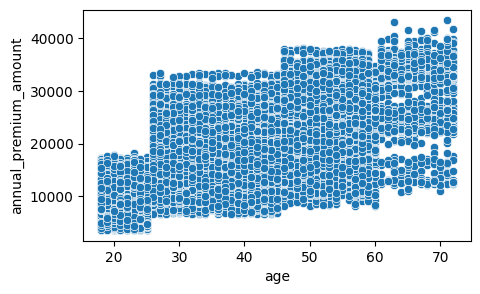

In [23]:
plt.figure(figsize=(5,3))
sns.scatterplot(df2, x='age' , y= 'annual_premium_amount')
plt.show()

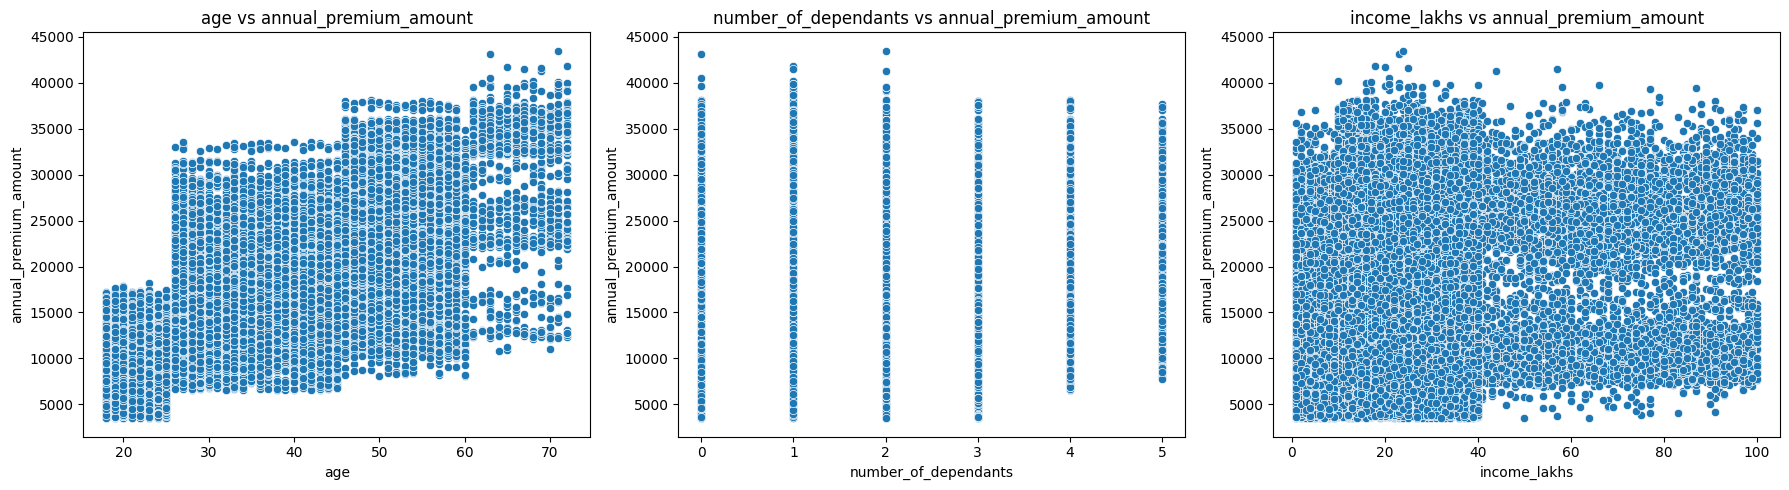

In [24]:
independent_vars = ['age', 'number_of_dependants', 'income_lakhs']
dependent_var = 'annual_premium_amount'

# Create 1 row with 3 scatterplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Loop through independent variables and plot
for i, col in enumerate(independent_vars):
    sns.scatterplot(data=df2, x=col, y=dependent_var, ax=axs[i])
    axs[i].set_title(f'{col} vs {dependent_var}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel(dependent_var)

# Adjust layout
plt.tight_layout()
plt.show()

##### Now Let's Analyse the Categorical columns:

In [25]:
df2.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053


In [26]:
categorical_columns = df2.select_dtypes(include='object').columns.tolist()
print(categorical_columns)

['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']


In [27]:
for col in categorical_columns:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [28]:
df2['smoking_status']= df2['smoking_status'].replace({
    'Smoking=0':'No Smoking',
    'Does Not Smoke' :'No Smoking',
    'Not Smoking': 'No Smoking'
})
df2.smoking_status.unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [29]:
df2.gender.value_counts()

gender
Male      27431
Female    22477
Name: count, dtype: int64

In [30]:
pct_count= df2.gender.value_counts(normalize=True)
pct_count

gender
Male      0.549631
Female    0.450369
Name: proportion, dtype: float64

In [31]:
pct_count.values

array([0.54963132, 0.45036868])

In [32]:
pct_count.index

Index(['Male', 'Female'], dtype='object', name='gender')

<Axes: xlabel='gender'>

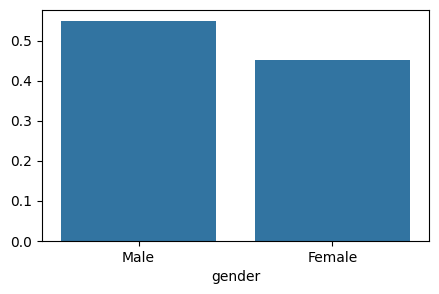

In [33]:
plt.figure(figsize=(5,3))
sns.barplot(x=pct_count.index, y=pct_count.values)

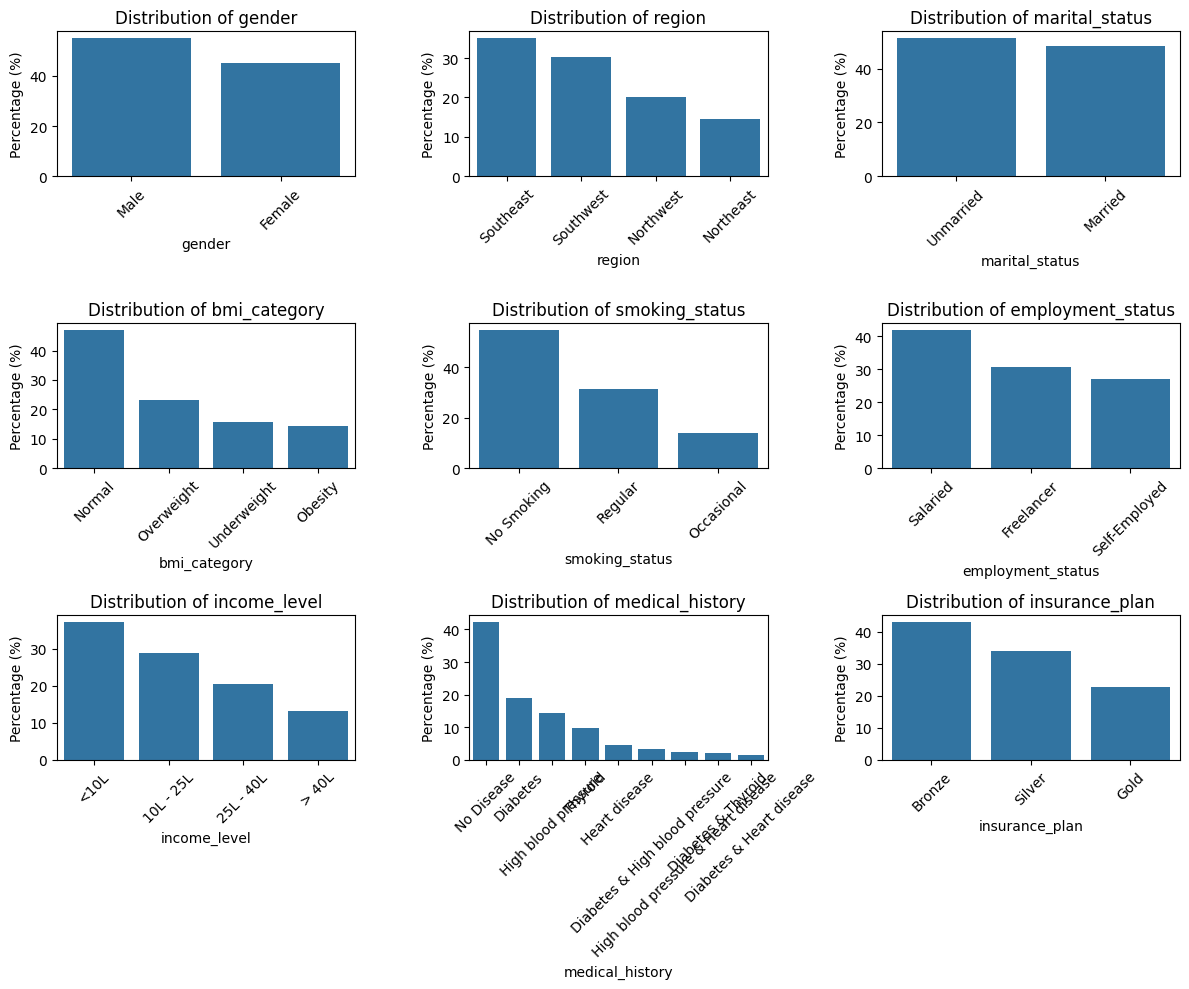

In [34]:
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
axs = axs.flatten()  # Flatten to 1D for easy indexing

# Plot each categorical column
for i, col in enumerate(categorical_columns):
    pct_count = df2[col].value_counts(normalize=True) * 100  # percentage
    sns.barplot(x=pct_count.index, y=pct_count.values, ax=axs[i])
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_ylabel('Percentage (%)')
    axs[i].set_xlabel(col)
    axs[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots (in case fewer than 9 columns)
for j in range(len(categorical_columns), len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.show()

##### In terms of Bivariate analysis If i wanna know the relation between two categorical columns i can use crosstab function of pandas

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


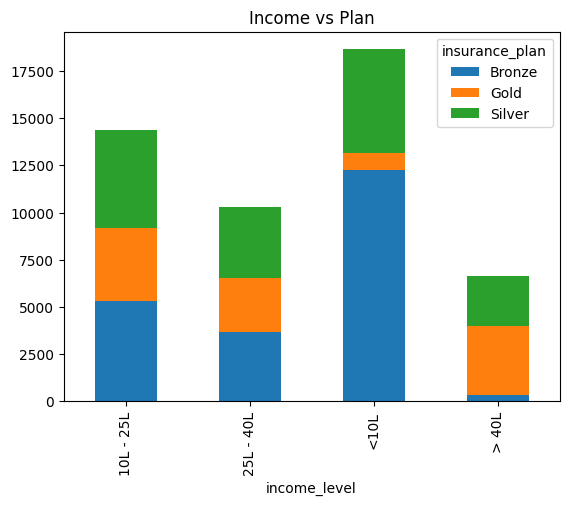

In [35]:
crosstab = pd.crosstab(df2['income_level'],df2['insurance_plan'])
print(crosstab)
crosstab.plot(kind='bar',stacked = True)
plt.title('Income vs Plan')
plt.show()

##### We can also use heatmap for visualize this as:

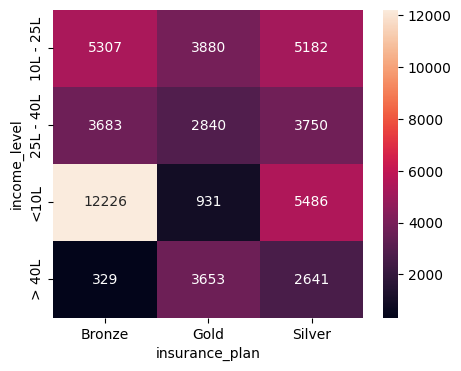

In [36]:
plt.figure(figsize=(5,4))
sns.heatmap(crosstab, annot= True, fmt= 'd')
plt.show()

### Feature Engineering

In [37]:
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [38]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [39]:
risk_scores= {
    'diabetes':6,
    'heart disease':8,
    'high blood pressure': 6,
    'thyroid':5,
    'no disease': 0,
    'none':0
}

df2[['disease1','disease2']] = df2['medical_history'].str.split(" & ", expand= True).apply(lambda x: x.str.lower())
df2.sample(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
28658,28,Male,Northwest,Married,2,Normal,Regular,Salaried,25L - 40L,32,High blood pressure & Heart disease,Silver,22394,high blood pressure,heart disease
470,37,Male,Northwest,Married,3,Normal,Regular,Salaried,> 40L,58,No Disease,Gold,22935,no disease,None
7309,39,Female,Southwest,Married,4,Underweight,No Smoking,Salaried,25L - 40L,39,Diabetes,Silver,16493,diabetes,None


In [40]:
#df2['disease1'].fillna('none',inplace =True)
#df2['disease2'].fillna('none',inplace =True)

df2.fillna({'disease1':'none','disease2':'none'}, inplace = True)
df2.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
disease1                 0
disease2                 0
dtype: int64

In [41]:
df2['total_risk_score'] = 0

for disease in ['disease1','disease2']:
    df2['total_risk_score'] +=  df2[disease].map(risk_scores) 

### Normalize the total_risk_column here only:
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/(max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571


##### Label Encoding for the Ordinal Columns

In [42]:
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [43]:
#### Let'sdo label encoding for insurance_plan column:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze':1, 'Silver':2, 'Gold':3})
df2.insurance_plan.unique()

array([1, 2, 3])

In [44]:
#### Doing same for income_label:

df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [45]:
df2['income_level'] = df2['income_level'].map({
    '<10L': 1,
    '10L - 25L': 2,
    '25L - 40L': 3,
    '> 40L': 4
})
df2['income_level'].unique()

array([1, 2, 4, 3])

In [46]:
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571


##### One Hot Encoding for the Nominal Columns

In [47]:
nominal_cols = ['gender', 'region','marital_status','bmi_category','smoking_status','employment_status']
df3 = pd.get_dummies(df2, columns= nominal_cols, drop_first=True, dtype=int)

In [48]:
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1


In [49]:
df3.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'medical_history', 'insurance_plan', 'annual_premium_amount',
       'disease1', 'disease2', 'total_risk_score', 'normalized_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

In [50]:
df4 = df3.drop(['medical_history','disease1','disease2','total_risk_score'],axis=1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


##### Plotting the correlation Matrix:

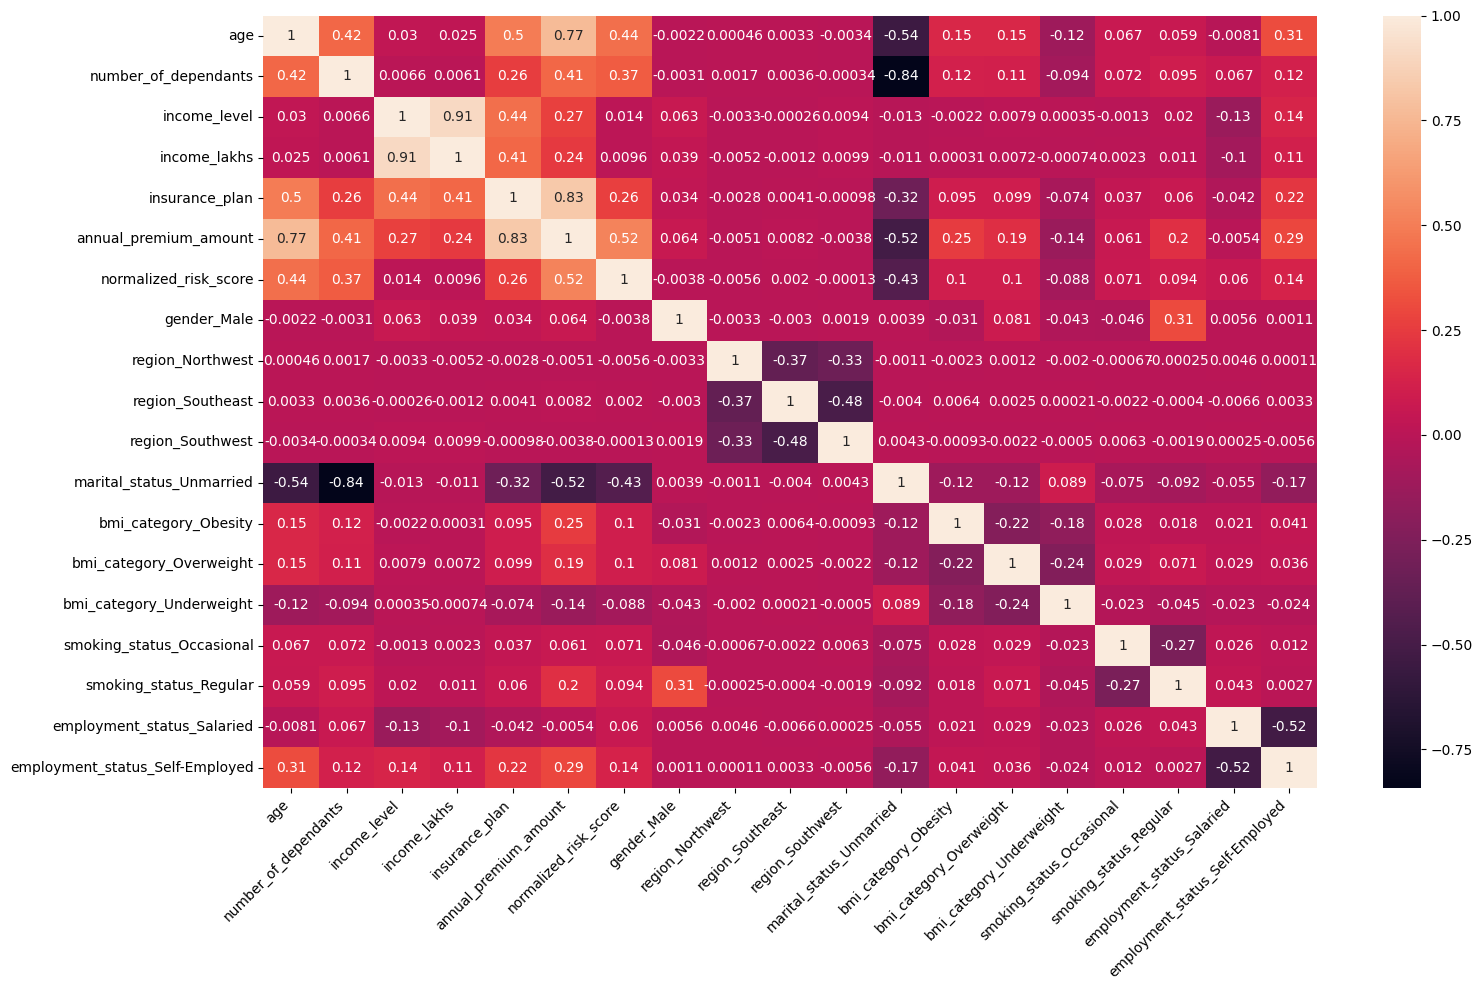

In [51]:
cm = df4.corr()

plt.figure(figsize=(16,10))
sns.heatmap(cm,annot= True)
plt.xticks(rotation =45, ha='right')
plt.yticks(rotation =0)
plt.tight_layout()
plt.show()

##### We can select the features for our model using this correlation matrix but VIF is a better solution for feature selection:

In [52]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


In [53]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

### Let's do scaling
from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age','number_of_dependants','income_level','income_lakhs','insurance_plan']
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
   vif_df = pd.DataFrame()
   vif_df['Feature'] = data.columns
   vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
   return vif_df

In [55]:
calculate_vif(X)

,Feature,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [56]:
calculate_vif(X.drop('income_level', axis='columns'))

,Feature,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [57]:
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head(10)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
5,0.703704,0.6,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1
6,0.277778,0.6,0.030303,0.5,0.857143,1,0,1,0,0,0,0,0,0,1,0,1
7,0.462963,0.6,0.454545,1.0,0.357143,1,0,0,0,0,0,1,0,0,1,1,0
8,0.759259,0.0,0.202020,1.0,0.000000,0,0,1,0,1,0,1,0,0,0,0,0
9,0.074074,0.0,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0


#### Model Training:

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state= 10)

print('x_train:', X_train.shape)
print('x_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

x_train: (34935, 17)
x_test: (14973, 17)
y_train: (34935,)
y_test: (14973,)


In [59]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

(0.9282143576916762, 0.9280547230217837)

In [60]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ===> MSE: ",mse_lr,"RMSE: ",rmse_lr)

Linear Regression ===> MSE:  5165611.913027984 RMSE:  2272.7982561212916


In [61]:
model_lr.intercept_

np.float64(4824.300272127099)

In [62]:
model_lr.coef_

array([11160.92646188,  -676.44399066,  -514.22981577, 12557.01293645,
        4810.35770228,   168.64666183,   -35.7192924 ,    39.96512973,
         -24.65292857,  -935.76061134,  3387.91145477,  1599.36226775,
         391.1713038 ,   735.91227798,  2234.8047119 ,   155.9846743 ,
         415.90397305])

##### We can show this coefficients in a horizontal bar chart to visualize how much it contributes to the final prediction.

In [63]:
X_test.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
3598,0.481481,0.4,0.343434,0.5,0.428571,1,0,1,0,1,0,1,0,0,1,1,0
35794,0.648148,0.6,0.202020,1.0,0.000000,1,0,0,0,0,1,0,0,1,0,1,0


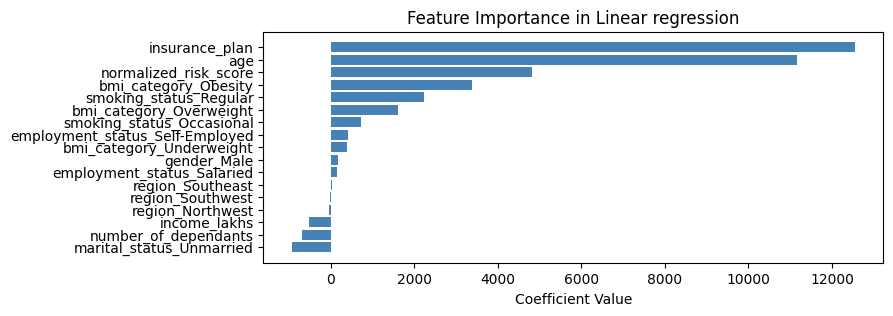

In [64]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index= X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by= 'Coefficients', ascending = True)


plt.figure(figsize =(8,3))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear regression')
plt.show()

##### Checking Score with Ridge() Model

In [65]:
model_rg = Ridge()
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score, test_score

(0.9282143198366275, 0.9280541644640345)

##### Going with XGBoost

In [66]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.9860964417457581, 0.9809534549713135)

In [67]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBRegressor ===> MSE: ",mse_xgb,"RMSE: ",rmse_xgb)

XGBRegressor ===> MSE:  1367525.625 RMSE:  1169.4125127601467


##### Using RandomizedSearchCV for hyperparameter tuning:

In [68]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators':[20,40,50],
    'learning_rate':[0.01, 0.1, 0.2],
    'max_depth':[3,4,5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42)
random_search.fit(X_train,y_train)
print(random_search.best_score_)
print(random_search.best_params_)

0.9809474547704061
{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}


In [69]:
best_model = random_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

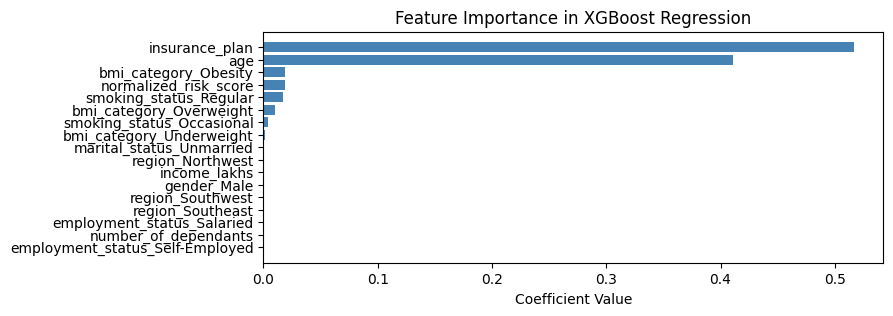

In [70]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances, index= X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by= 'Coefficients', ascending = True)

plt.figure(figsize =(8,3))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost Regression')
plt.show()

### Error Analysis:

In [71]:
y_pred = best_model.predict(X_test)
residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

result_df= pd.DataFrame({
    'actuals': y_test,
    'predicted':y_pred,
    'diff': residuals,
    'diff_pct':residuals_pct
})
result_df.head()

,actuals,predicted,diff,diff_pct
3598,20554,20334.953125,-219.046875,-1.065714
35794,29647,29378.779297,-268.220703,-0.904714
43608,20560,20618.185547,58.185547,0.283004
42730,5018,7352.829590,2334.829590,46.529087
18936,8929,8203.291992,-725.708008,-8.127540


<Axes: xlabel='diff_pct', ylabel='Count'>

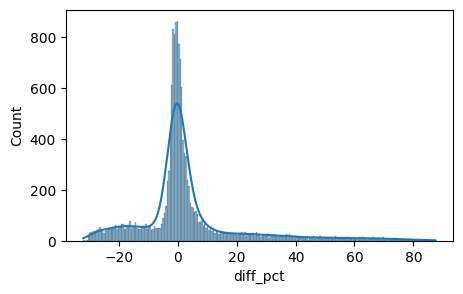

In [72]:
plt.figure(figsize=(5,3))
sns.histplot(result_df['diff_pct'], kde = True)

##### We have decided that the maximum error should be less than 10%.

In [73]:
extreme_error_threshold = 10
extreme_results_df = result_df[np.abs(result_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(4487, 4)

In [74]:
result_df.shape

(14973, 4)

In [75]:
#### Finding the percentage of extreme errors:

extreme_error_pct = extreme_results_df.shape[0]*100/result_df.shape[0]
extreme_error_pct

29.967274427302478

##### Now I want to find where exactly is the problem:

In [76]:
extreme_results_df.index

Index([42730, 20029,  4294, 44419,  6707, 11728, 15740, 35065,  9654, 22679,
       ...
       36158, 30386, 21184, 45020,  8249,  8767, 25179, 21592, 49274, 27977],
      dtype='int64', length=4487)

In [77]:
X_test.index

Index([ 3598, 35794, 43608, 42730, 18936, 45416, 20029,  4294, 39145,  3152,
       ...
        4554,  9086,  8767,   603, 25179,  5621,  6069, 21592, 49274, 27977],
      dtype='int64', length=14973)

In [78]:
extreme_errors_df = X_test.loc[extreme_results_df.index] ### SO these are the rows that have high margin errors.
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
4294,0.000000,0.2,0.020202,0.0,0.000000,1,0,0,1,1,0,1,0,0,0,0,0
44419,0.055556,0.0,0.242424,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,0,0
6707,0.111111,0.2,0.070707,0.5,0.000000,1,0,0,0,1,0,0,1,0,0,0,0


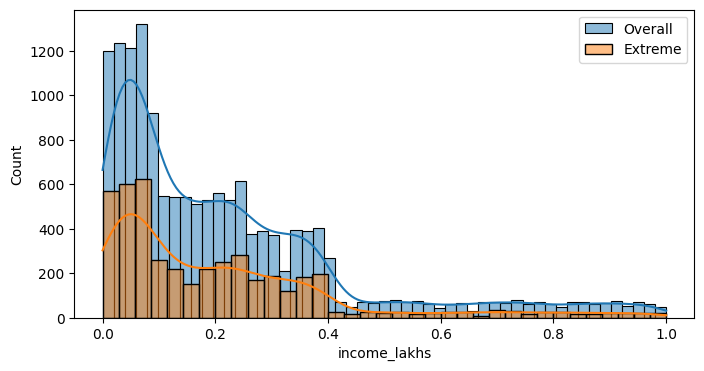

In [85]:
plt.figure(figsize=(8, 4))
sns.histplot(X_test.income_lakhs, label="Overall", kde = True)
sns.histplot(extreme_errors_df.income_lakhs, label="Extreme", kde = True)
plt.legend()
plt.show()

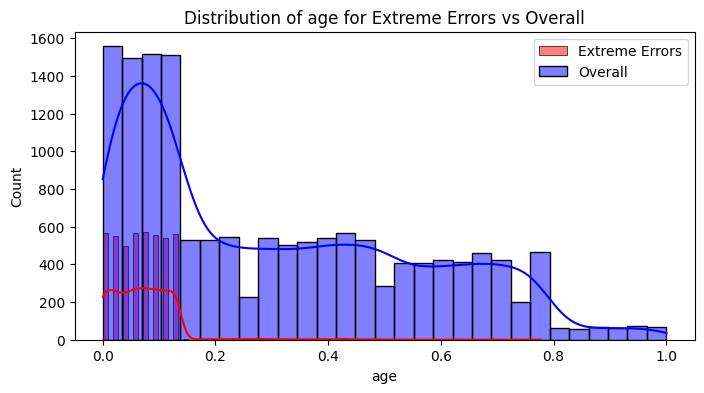

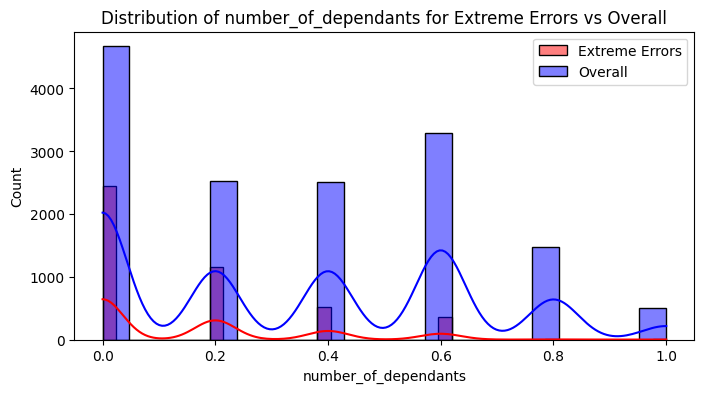

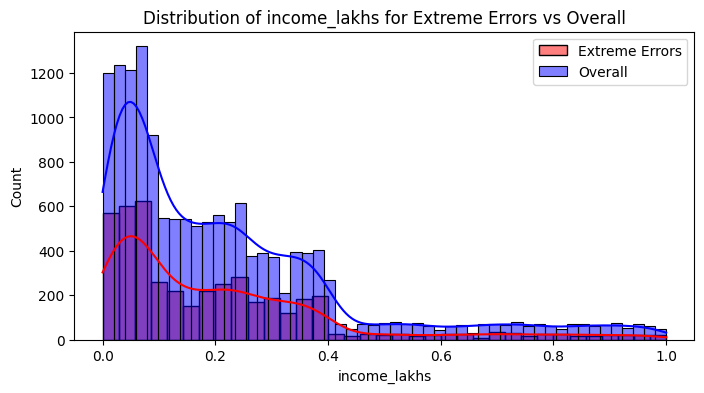

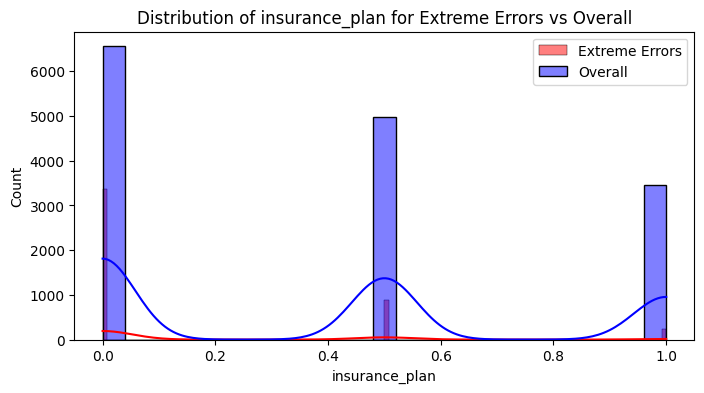

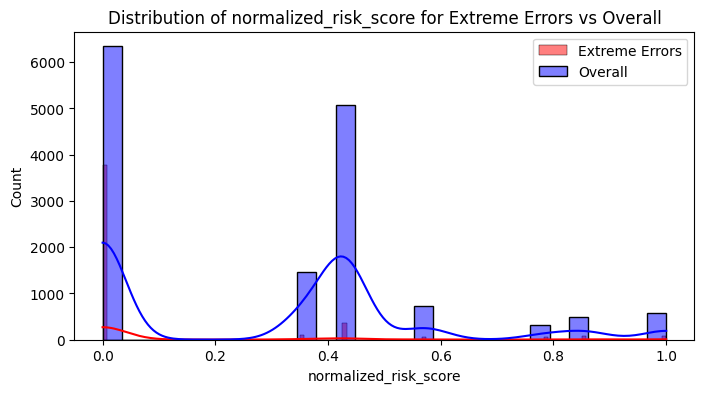

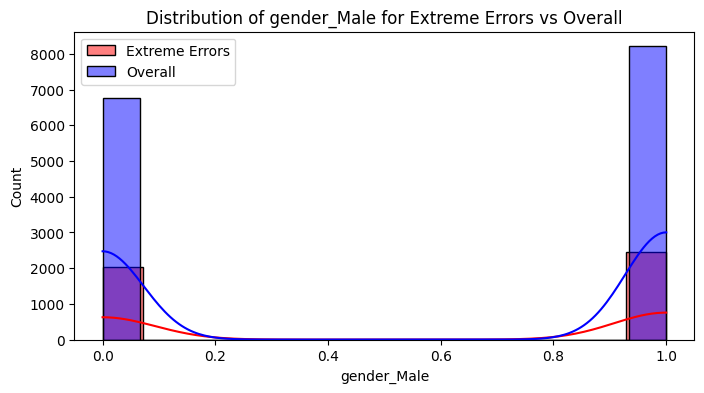

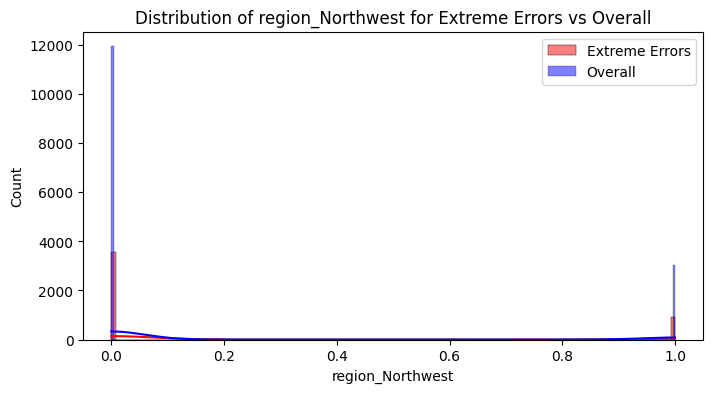

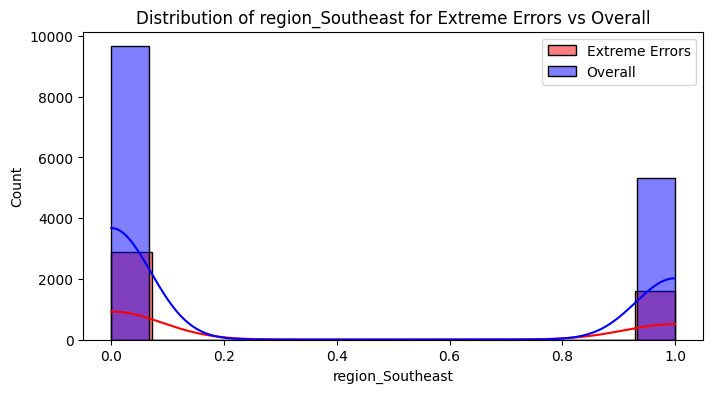

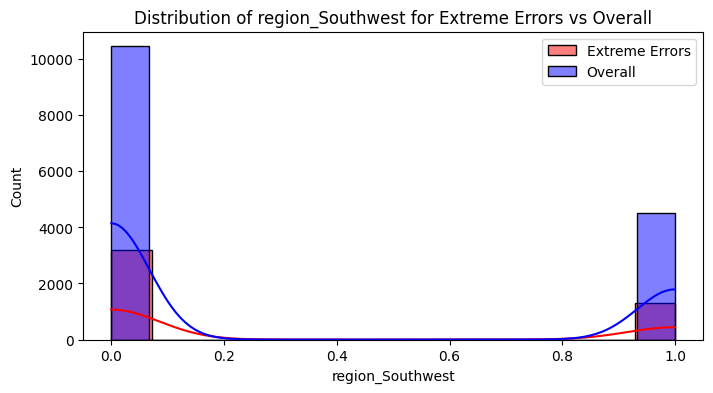

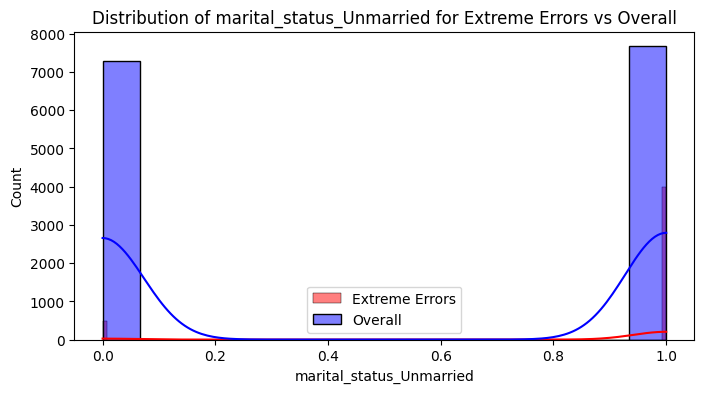

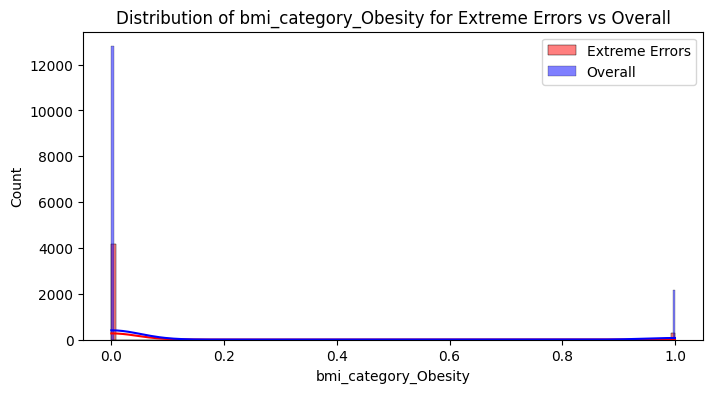

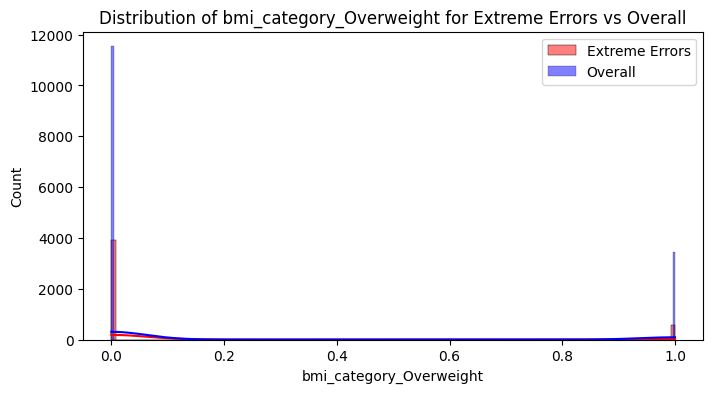

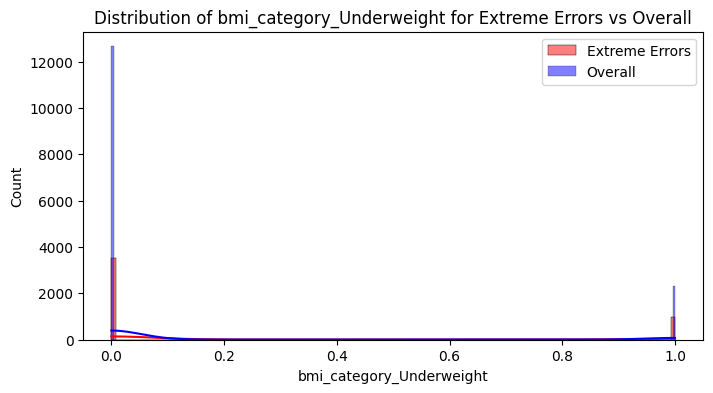

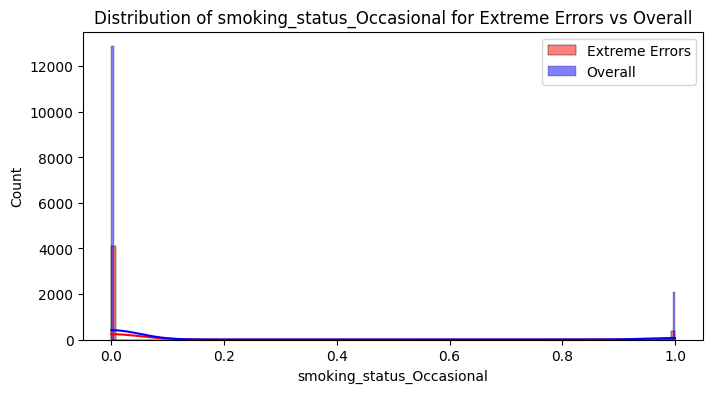

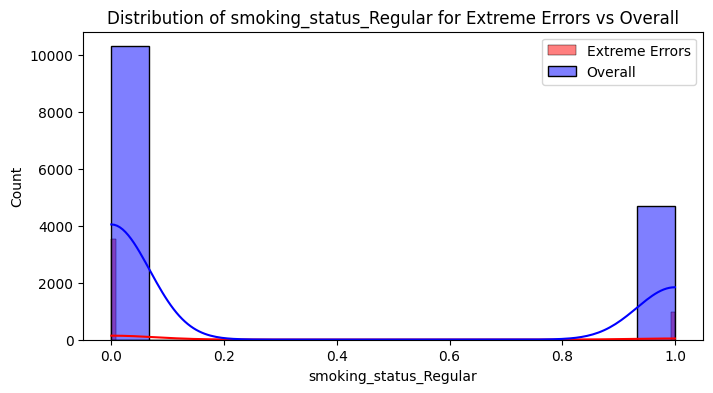

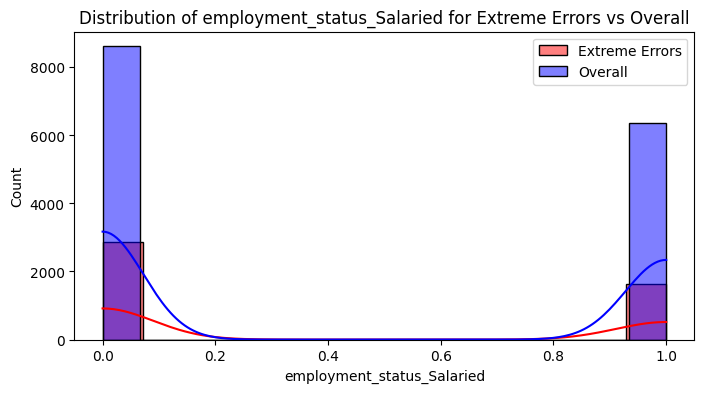

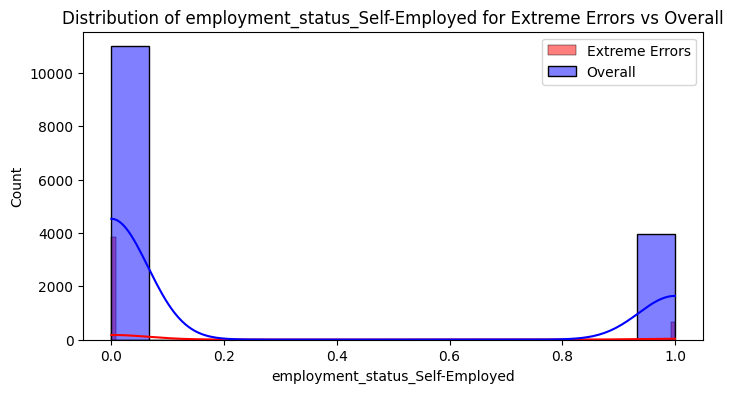

In [81]:
for feature in X_test.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

##### Here we can see that the Age column has some problem

#### Reverse Scaling

In [82]:
extreme_errors_df['income_level']=-1

In [83]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,23.0,1.0,-2.0,14.0,1.0
1,19.0,1.0,-2.0,4.0,1.0
2,18.0,1.0,-2.0,3.0,1.0
3,21.0,0.0,-2.0,25.0,1.0
4,24.0,1.0,-2.0,8.0,2.0


<Axes: xlabel='age', ylabel='Count'>

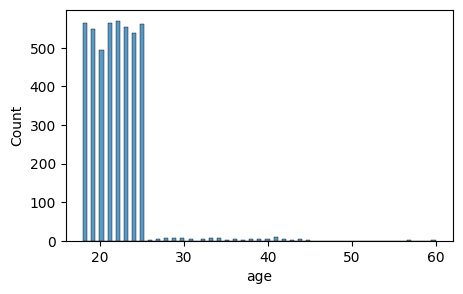

In [84]:
plt.figure(figsize=(5,3))
sns.histplot(df_reversed.age)